In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os
from lmfit import Model, Parameters
from scipy.optimize import curve_fit, leastsq

In [2]:
def phase_min(phase, cmplx):
    return np.linalg.norm((cmplx * np.exp(-2 * np.pi * phase/360 * 1j)).imag)


def phase_finder(phase, cmplx):
    return (cmplx * np.exp(-2 * np.pi * phase/360 * 1j)).imag


def t1(x, p1, p2, p3, p4):
    return p1 * (1 - 2*np.exp(-(x/p2)**p3)) + p4


def refit_t1(x, p1, p4):
    return p1 * (1 - 2*np.exp(-(x/t1)**beta_t1)) + p4


def t2(x, p1, p2, p3, p4):
    return p1 * (1 - 2*np.exp(-(2*x/p2)**p3)) + p4


def f2(tm, tau, beta, Z, M0, Moff):
    # p1 * (1 - 2*np.exp(-(x/p2)**p3)) + p4
    return M0 * ((1 - Z) * np.exp(-(tm/tau)**beta) + Z) * np.exp(-(tm/t1)**beta_t1) + Moff


def kohlrausch(x, M0, tau, beta, Moff):
    return M0 * np.exp(-(x/tau)**beta) + Moff

krmodel = Model(kohlrausch)

In [23]:
def load_ts():
    fn_nmr = glob.glob("*.dat.nmr")[0]
    data_nmr = np.loadtxt(fn_nmr)
    tm = data_nmr[:,0]

    fn_ts = glob.glob("*.ts")
    fn_ts = sorted(fn_ts, key=lambda a: int(a.split("_")[-1].split(".")[0]))
    time = np.loadtxt(fn_ts[0])[:,0]

    real = np.empty((len(fn_ts), np.loadtxt(fn_ts[0]).shape[0]))
    imag = np.empty((len(fn_ts), np.loadtxt(fn_ts[0]).shape[0]))
    for i, fn_tsi in enumerate(fn_ts):
        data_tsi = np.loadtxt(fn_tsi)
        real[i] = data_tsi[:,1]
        imag[i] = data_tsi[:,3]

    return tm, time, real, imag


def load_data():
    fn_nmr = glob.glob("*.dat.nmr")[0]
    data_nmr = np.loadtxt(fn_nmr)
    tm = data_nmr[:,0]
    real = data_nmr[:,5]
    real_err = data_nmr[:,6]
    imag = data_nmr[:,7]
    imag_err = data_nmr[:,8]
    return tm, real, real_err, imag, imag_err


def pick_peaks(time, real, imag):
    echo_time = 18e-6
    echo_width = 4e-6
    echo_begin = echo_time - echo_width / 2
    echo_end = echo_time + echo_width / 2
    echo_begin_index = np.argmin(np.abs(time - echo_begin))
    echo_end_index = np.argmin(np.abs(time - echo_end))

    echo_real = np.mean(real[:,echo_begin_index:echo_end_index], axis=1)
    echo_imag = np.mean(imag[:,echo_begin_index:echo_end_index], axis=1)
    
    return echo_real, echo_imag


#def select_data(skip_start, skip_end, tm, echo_real, echo_imag):
#    end_index = tm.size - skip_end
#    return (tm[skip_start:end_index], echo_real[skip_start:end_index], 
#                                           echo_imag[skip_start:end_index])


def phase_shift(phase, cmplx):
    return cmplx * np.exp(-2 * np.pi * phase/360 * 1j)


def to_cmplx(real, imag):
    cmplx = np.empty(real.shape, dtype=complex)
    cmplx.real = real
    cmplx.imag = imag
    return cmplx


# def find_phase(start, end, steps, cmplx):
#     min_imag = np.inf
#     min_phase = 0
#     min_cmplx = np.empty(cmplx.shape, dtype=complex)
#     for phase in np.linspace(start, end, steps):
#         cmplx_p = phase_shift(phase, cmplx)
#         img_norm = np.linalg.norm(cmplx_p.imag)
#         if img_norm < min_imag:
#             min_imag = img_norm
#             min_phase = phase
#             min_cmplx = cmplx_p
#     return min_phase, min_cmplx


def phase_fit(cmplx, start_phase):
    # phase = minimize(phase_min, start_phase, args=cmplx).x
    phase = leastsq(phase_finder, start_phase, args=cmplx)[0]
    return phase, phase_shift(phase, cmplx)


def sort_values(time, data):
    return np.sort(time), data[np.argsort(time)]


def fit_f2(tm, cmplx, sigma=None):
    startwerte = [1e-4, 0.6, 0.6, 400, 0]
    p = curve_fit(f2, tm, cmplx.real, p0=startwerte, sigma=sigma, absolute_sigma=True)[0]
    tau, beta, Z, M0, Moff = p
    fit = f2(tm, tau, beta, Z, M0, Moff)
    return p, fit


def fit_refit_t1(tm, cmplx, sigma=None):
    p = curve_fit(refit_t1, tm, cmplx.real, p0=[-80, -80], sigma=sigma, absolute_sigma=True)[0]
    fit = refit_t1(tm, p[0], p[1])
    return p, fit


def plot_fit(tm, fit, p, label=""):
    # plt.text(4e-2, -1000, "$T_1$ = {} ms".format(np.round(p[1] * 1000, decimals=3)), fontsize=10)
    # plt.text(4e-2, -1500, "$\\beta$ = {}".format(np.round(p[2], decimals=3)), fontsize=10)
    plt.xscale("log")
    plt.plot(tm, fit, label=label)


def plot_cmplx(tm, cmplx, label=""):
    plt.xscale("log")
    plt.scatter(tm, cmplx.real, marker="x", label=label)


def plot_data(tm, data, label=""):
    plt.xscale("log")
    plt.scatter(tm, data, marker="x", label=label)


def plot_descriptions():
    plt.legend()
    plt.xlabel("Zeit [s]")
    plt.ylabel("a.u.")
    plt.title("CRN $T_1$ an F2, coscos")


def plot_limits(xmin=None, xmax=None, ymin=None, ymax=None):
    xmin_orig, xmax_orig = plt.xlim()
    ymin_orig, ymax_orig = plt.ylim()
    if xmin is None:
        xmin = xmin_orig
    if xmax is None:
        xmax = xmax_orig
    if ymin is None:
        ymin = ymin_orig
    if ymax is None:
        ymax = ymax_orig
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)


def show_plot():
    plot_descriptions()
    plt.show()


def save_plot(fn=None):
    plot_descriptions()
    file_types = ["pdf", "svg"]
    fn_save = "/home/jens/Documents/projekte/crn/170713/plots/diff_cc"
    if fn is not None:
        fn_save = fn
    for file_type in file_types:
        plt.savefig(fn_save + "." + file_type, bbox_inches="tight")

        
def select_data(start, end, data, indexor=None, remove=False, select_indexor=False):
    mask = []
    if indexor is None:
        mask = (data >= start) & (data < end)
    else:
        mask = (indexor >= start) & (indexor < end)
    if remove is True:
        mask = np.invert(mask)
    if select_indexor is True:
        return data[mask], indexor[mask]
    else:
        return data[mask]

/home/jens/Documents/projekte/crn/170714/1329_CRN_F2_310K/
[ 2.05390256]
[  4.78994946e-03   9.66810211e-01   3.22017045e-01   4.88209387e+02
   1.11557751e+00]
[[Model]]
    Model(kohlrausch)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 24
    # variables        = 4
    chi-square         = 0.021
    reduced chi-square = 0.001
    Akaike info crit   = -160.566
    Bayesian info crit = -155.854
[[Variables]]
    M0:     0.65907642 +/- 0.022877 (3.47%) (init= 0.8)
    tau:    0.00458551 +/- 0.000399 (8.70%) (init= 0.005)
    beta:   1.02051816 +/- 0.105251 (10.31%) (init= 1)
    Moff:   0.33937157 +/- 0.017208 (5.07%) (init= 0.3)
[[Correlations]] (unreported correlations are <  0.100)
    C(M0, Moff)                  = -0.835 
    C(tau, Moff)                 = -0.645 
    C(M0, beta)                  = -0.631 
    C(M0, tau)                   =  0.400 
    C(beta, Moff)                =  0.388 
    C(tau, beta)                 = -0.277 

/home/jens/Documents/

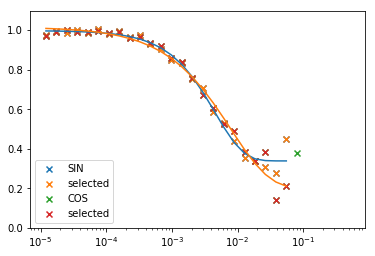

In [37]:
t1data = np.loadtxt("/home/jens/Documents/projekte/crn/170713/T1_300_310.txt")

home_dir = "/home/jens/Documents/projekte/crn/170714"
labels = ["SIN",
          "COS"]


def f2_analysis(directory):
    os.chdir(directory)
    print(directory)

    t1 = t1data[(2*i)+1, 3]
    beta_t1 = t1data[(2*i)+1, 4]

    # tm, time, real, imag = load_ts()
    # real, imag = pick_peaks(time, real, imag)
    tm, real, real_err, imag, imag_err = load_data()
    cmplx = to_cmplx(real, imag)
    phase, cmplx = phase_fit(cmplx, -15)
    tm, cmplx = sort_values(tm, cmplx)
    print(phase)

    # p, fit = fit_refit_t1(tm, cmplx, sigma=real_err)
    p, fit = fit_f2(tm, cmplx, sigma=real_err)
    tau, beta, Z, M0, Moff = p
    print(p)

    # plot_fit(tm, fit, p)
    # plt.errorbar(tm, cmplx.real, yerr=real_err, fmt="x", label=labels[i])
    # plot_cmplx(tm, cmplx, label=labels[i])
    # plot_cmplx(tm, cmplx/fit, label=labels[i])
    
    result = (cmplx - Moff) / M0 / np.exp(-(tm/t1)**beta_t1)
    plot_cmplx(tm, result, label=labels[i])
    plot_limits(ymin=0.0, ymax=1.1)
    # plot_fit(tm, fit / ((1-Z) * np.exp(-(tm/tau)**beta) + Z), p, label=labels[i])
    
    return tm, result

    
for i, directory in enumerate(sorted(glob.glob(home_dir + "/*/"))):
    tm, result = f2_analysis(directory)
    result, tm = select_data(0.0, 0.06, result.real, indexor=tm, select_indexor=True)
    plot_data(tm, result, label="selected")
    params = Parameters()
    params.add("M0", value=0.8, min=0)
    params.add("tau", value=5e-3, min=0)
    params.add("beta", value=1.0, min=0)
    params.add("Moff", value=0.3)
    result = krmodel.fit(result, params, x=tm)
    plt.plot(tm, result.best_fit)
    print(result.fit_report())

plt.legend(loc=3)

f2_fit = plt.gcf()

In [39]:
f2_fit.savefig("/home/jens/Documents/projekte/crn/analyse/plots/f2_fit.pdf", bbox_inches="tight")
f2_fit.savefig("/home/jens/Documents/projekte/crn/analyse/plots/f2_fit.svg", bbox_inches="tight")
f2_fit.savefig("/home/jens/Documents/projekte/crn/analyse/plots/f2_fit.jpg", bbox_inches="tight")